In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from synthpop import Synthpop
import matplotlib.pyplot as plt
from helper_functions import *
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings('ignore')

### 1. Load data and data preperation

In [2]:
admissions_df = pd.read_csv('../datasets/data/bar_pass_prediction.csv', index_col=False)
print(admissions_df.shape)
print(admissions_df.columns)
print(admissions_df.isnull().sum())
display(admissions_df.head())

(22407, 39)
Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')
decile1b                   1604
decile3                    1604
ID                            0
decile1                    1092
sex                           5
race                         16
cluster                      96
lsat                          0
ugpa                          0
zfygpa                      984
DOB_yr                       50
grad                          3
zgpa                       1289
bar1                          0
bar1_yr                      39
bar2                          0
bar2_yr             

,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


In [3]:
# Remove all rows with missing values
admissions_df = admissions_df.dropna()
print(admissions_df.shape)
print(admissions_df.isnull().sum())

(20427, 39)
decile1b                   0
decile3                    0
ID                         0
decile1                    0
sex                        0
race                       0
cluster                    0
lsat                       0
ugpa                       0
zfygpa                     0
DOB_yr                     0
grad                       0
zgpa                       0
bar1                       0
bar1_yr                    0
bar2                       0
bar2_yr                    0
fulltime                   0
fam_inc                    0
age                        0
gender                     0
parttime                   0
male                       0
race1                      0
race2                      0
Dropout                    0
other                      0
asian                      0
black                      0
hisp                       0
pass_bar                   0
bar                        0
bar_passed                 0
tier                       0
in

**UI text**

A subset of the [Law School Admission Bar*](https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage) dataset is used as a demo. Synthetic data will be generated for the following columns: 

- sex: student gender, i.e. 1 (male), 2 (female)
- race1: race, i.e. asian, black, hispanic, white, other
- ugpa: The student's undergraduate GPA, continous variable;
- bar: Ground truth label indicating whether or not the student passed the bar, i.e. passed 1st time, passed 2nd time, failed, non-graduated

The CART method will be used  evaluate the distribution and correlation differences between the real and synthetic data.

*The original paper can be found [here](https://files.eric.ed.gov/fulltext/ED469370.pdf).

In [4]:
# demo dataset
df = admissions_df[['sex', 'race1', 'ugpa', 'bar']]
df.head()

,sex,race1,ugpa,bar
0,1.0,white,3.5,a Passed 1st time
1,1.0,white,3.5,a Passed 1st time
2,2.0,white,3.5,a Passed 1st time
3,2.0,white,3.5,a Passed 1st time
4,2.0,white,3.5,a Passed 1st time


#### 1.1 Data type detection

In [5]:
# get the data types of columns using helper function
dtypes_dict = data_type(df)
dtypes_dict

{'sex': 'float', 'race1': 'category', 'ugpa': 'float', 'bar': 'category'}

In [6]:
# change sex data type to categorical
dtypes_dict['sex'] = 'category'
df['sex'] = df['sex'].map({1: 'male', 2: 'female'})

In [7]:
## UI text
print('In the attached data, columns have the following data types:')
for key, value in dtypes_dict.items():
    print(f'{key}: {value}')

In the attached data, columns have the following data types:
sex: category
race1: category
ugpa: float
bar: category


In [8]:
# encode categorical data to numeric values
df_encoded, label_encoders = encode_data(df)
df_encoded.head()

,sex,race1,ugpa,bar
0,1,4,3.5,0
1,1,4,3.5,0
2,0,4,3.5,0
3,0,4,3.5,0
4,0,4,3.5,0


#### 1.2 Create combined dataframe with placeholders for synthetic data

In [9]:
# copy dataframe and assign NaN to all values
synth_df = df.copy()
synth_df[:] = np.nan

# combine empty synthetic data with original data and with encoded data 
combined_data = pd.concat((df.assign(realOrSynthetic='real'), synth_df.assign(realOrSynthetic='synthetic')), keys=['real','synthetic'], names=['Data'])
combined_data_encoded = pd.concat((df_encoded.assign(realOrSynthetic='real_encoded'), synth_df.assign(realOrSynthetic='synthetic')), keys=['real_encoded','synthetic'], names=['Data'])
combined_data.head()

sex  race1  ugpa                bar realOrSynthetic
Data                                                          
real 0    male  white   3.5  a Passed 1st time            real
     1    male  white   3.5  a Passed 1st time            real
     2  female  white   3.5  a Passed 1st time            real
     3  female  white   3.5  a Passed 1st time            real
     4  female  white   3.5  a Passed 1st time            real

In [10]:
combined_data_encoded.head()

sex race1  ugpa bar realOrSynthetic
Data                                              
real_encoded 0   1     4   3.5   0    real_encoded
             1   1     4   3.5   0    real_encoded
             2   0     4   3.5   0    real_encoded
             3   0     4   3.5   0    real_encoded
             4   0     4   3.5   0    real_encoded

In [11]:
combined_data.tail()

sex race1  ugpa  bar realOrSynthetic
Data                                                 
synthetic 22402  NaN   NaN   NaN  NaN       synthetic
          22403  NaN   NaN   NaN  NaN       synthetic
          22404  NaN   NaN   NaN  NaN       synthetic
          22405  NaN   NaN   NaN  NaN       synthetic
          22406  NaN   NaN   NaN  NaN       synthetic

#### 1.3 Explanatory data analysis

##### 1.3.1 Univariate distributions

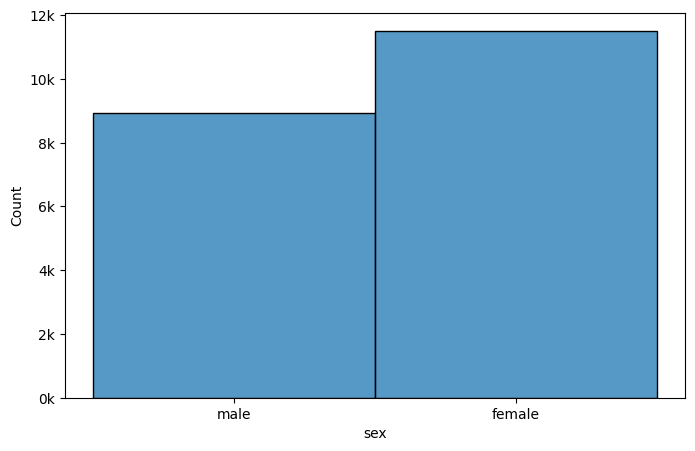

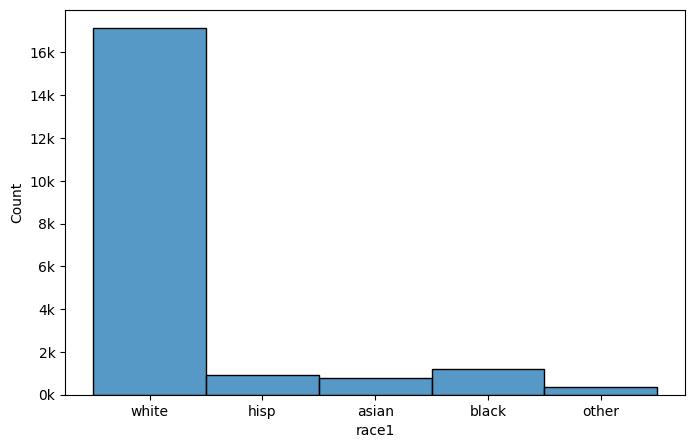

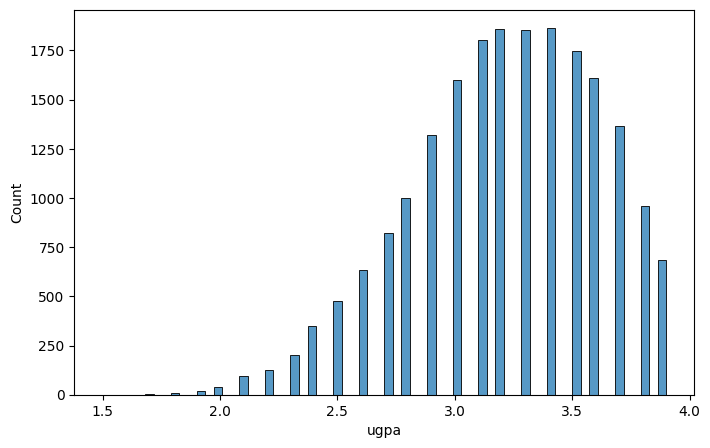

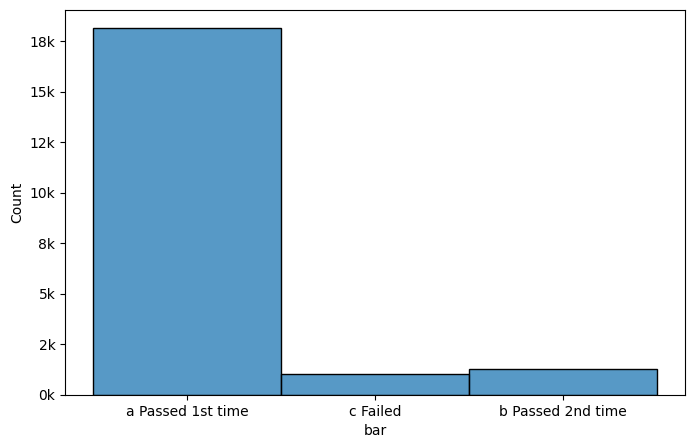

In [12]:
# plot univariate histograms using helper function
univariate_hist(df,dtypes_dict)

##### 1.3.2 Bivariate distributions

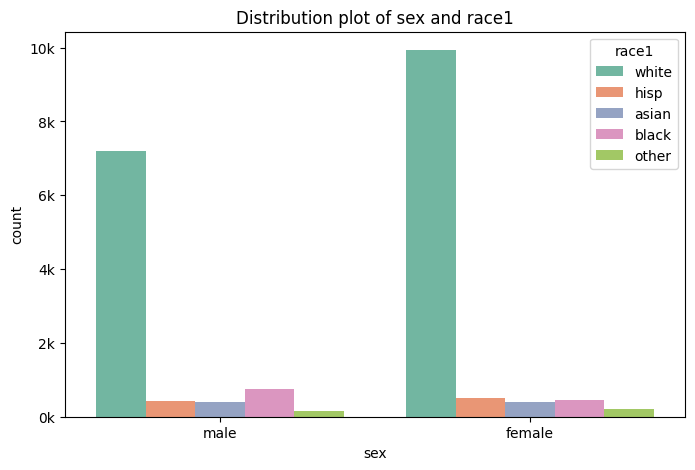

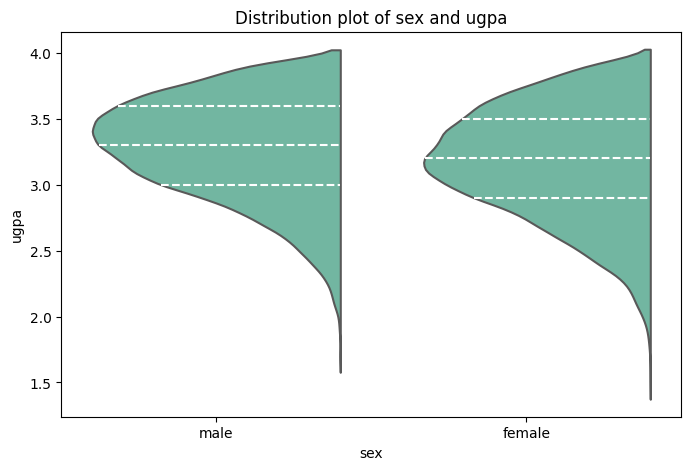

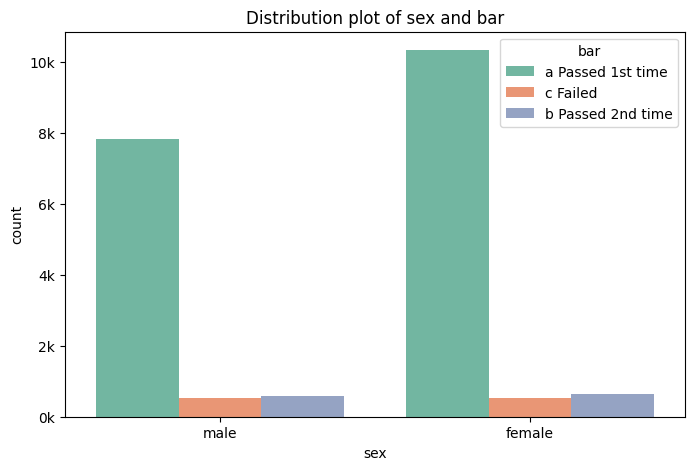

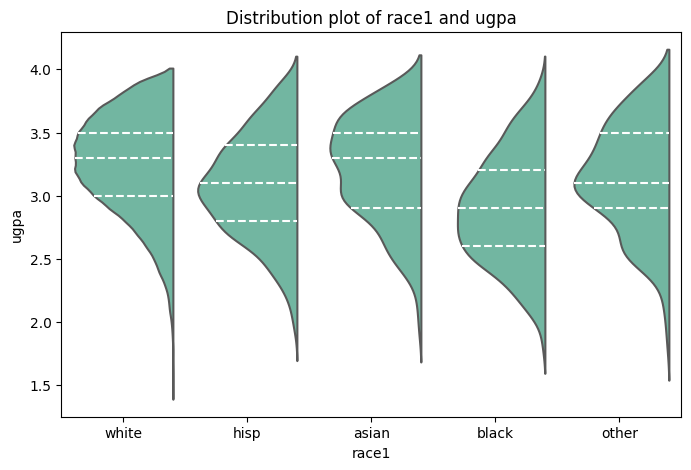

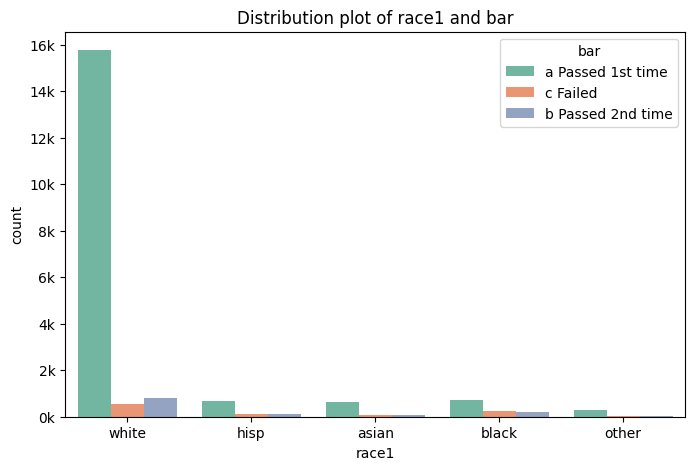

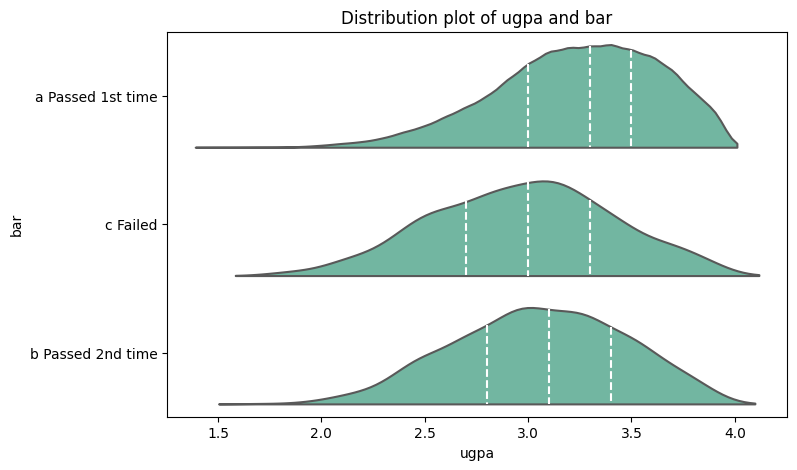

In [13]:
bivariate_plot(df, combined_data, dtypes_dict)

##### 1.3.3 Correlation matrix

Text(0.5, 1.0, 'Correlation matrix of attached data')

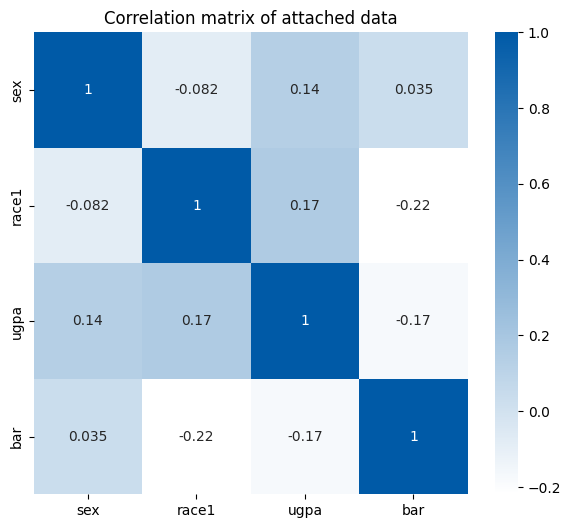

In [14]:
plt.figure(figsize=(7, 6))
cmap = LinearSegmentedColormap.from_list('custom_blues', ['#ffffff', '#005AA7'])
sns.heatmap(df_encoded.corr(), annot=True, cmap=cmap)
plt.title('Correlation matrix of attached data')

**UI text**

In the generated synthetic data, our objective is to capture the one-dimensional, two-dimensional, and higher-dimensional relationships between variables in the dataset. The plots above will be used to evaluate how effectively these relationships are represented in the synthetic data.

### 2. CART model

**UI text**

The CART (Classification and Regression Trees) method generates synthetic data by learning patterns from real data through a decision tree that splits data into homogeneous groups based on feature values. It predicts averages for numerical data and assigns the most common category for categorical data, using these predictions to create new synthetic points.

In [15]:
# Initialize Synthpop object with method 'cart'
spop = Synthpop(method='cart')

# Fit the Synthpop model
spop.fit(df_encoded, dtypes=dtypes_dict)

True2
True2
       sex  race1  ugpa  bar
0        1      4   3.5    0
1        1      4   3.5    0
2        0      4   3.5    0
3        0      4   3.5    0
4        0      4   3.5    0
...    ...    ...   ...  ...
22402    0      1   1.8    2
22403    0      1   1.8    2
22404    0      1   1.8    0
22405    0      4   1.5    0
22406    0      4   1.6    0

[20427 rows x 4 columns]
train_sex
train_race1
train_ugpa
train_bar


In [16]:
# Generate synthetic data
n_synth_data = df_encoded.shape[0]
synth_df = spop.generate(n_synth_data)

generate_sex
generate_race1
generate_ugpa
generate_bar


In [17]:
# preview of synthetic data
synth_df.head()

,sex,race1,ugpa,bar
0,0,4,2.9,1
1,0,4,3.1,1
2,0,4,2.8,0
3,0,2,2.5,0
4,1,0,2.8,2


### 3. Evaluation of generated data

In [18]:
# decode synthetic data using the label encoders
synth_df_decoded = synth_df.copy()
for column in synth_df_decoded.columns:
    if column in label_encoders:
        synth_df_decoded[column] = label_encoders[column].inverse_transform(synth_df_decoded[column])
synth_df_decoded.head()

,sex,race1,ugpa,bar
0,female,white,2.9,b Passed 2nd time
1,female,white,3.1,b Passed 2nd time
2,female,white,2.8,a Passed 1st time
3,female,hisp,2.5,a Passed 1st time
4,male,asian,2.8,c Failed


In [19]:
# combine original data and decoded synthetic data in dataframe
combined_data = pd.concat((df.assign(realOrSynthetic='real'), synth_df_decoded.assign(realOrSynthetic='synthetic')), keys=['real','synthetic'], names=['Data'])

#### 3.1 Univariate distributions

**UI text**

{n_synth_data} synthetic data points are generated using CART. The figures below display the differences in value frequency for each variable. A grey bar chart indicates the amount of values is equally represented in the synthetic data and in the real data. A bar chart with an orange top indicates that the synthetic data containes more values for this variable compared to the real data. Conversely, a bar chart with a blue top shows that the synthetic data contains fewer values for this variable than the real data.

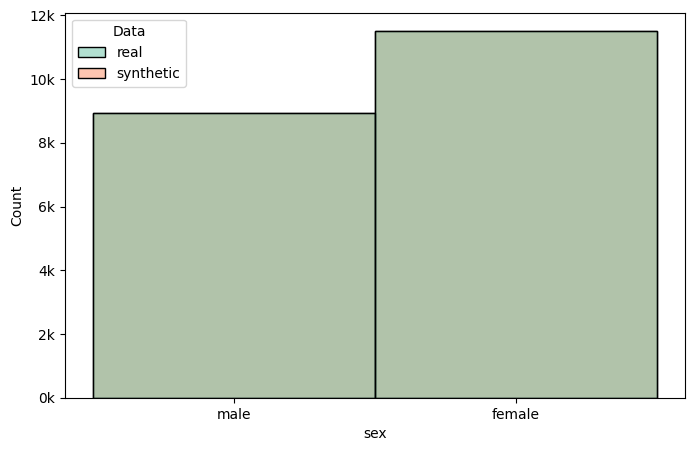

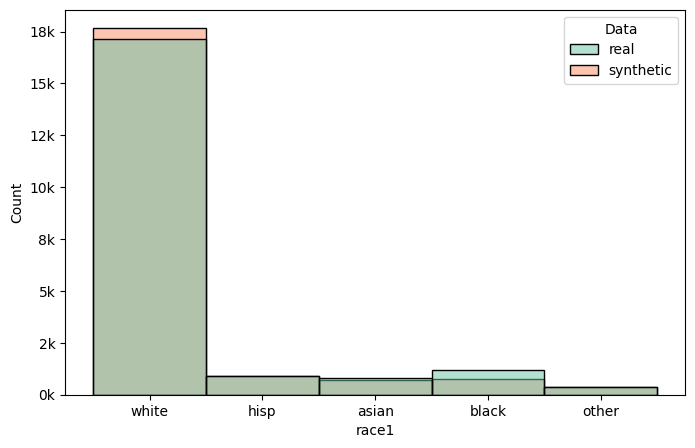

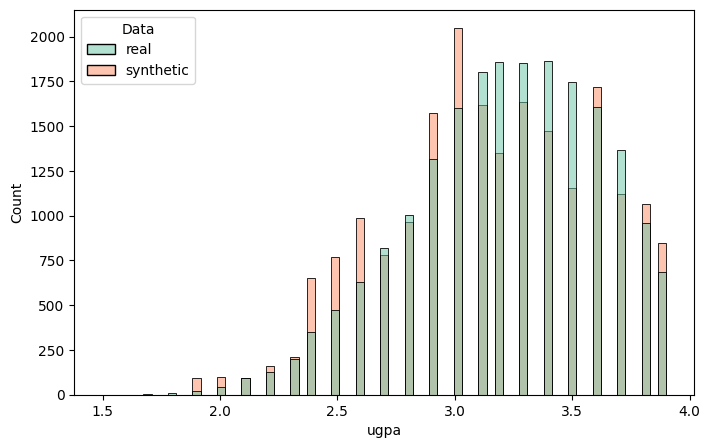

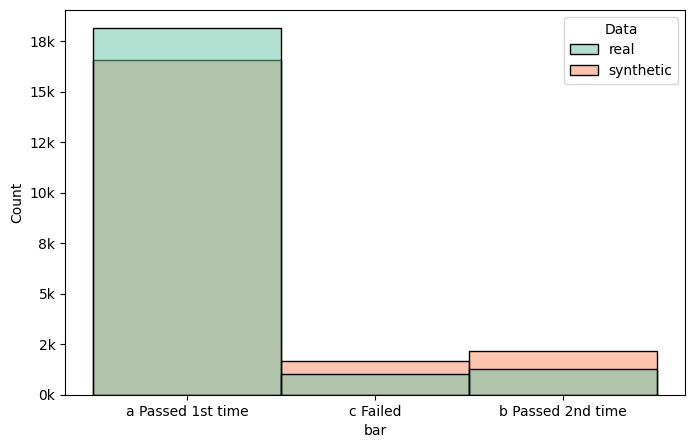

In [20]:
# plot univariate histograms using helper function
univariate_hist(combined_data,dtypes_dict,Comparison=True)

#### 3.2 Bivariate distributions

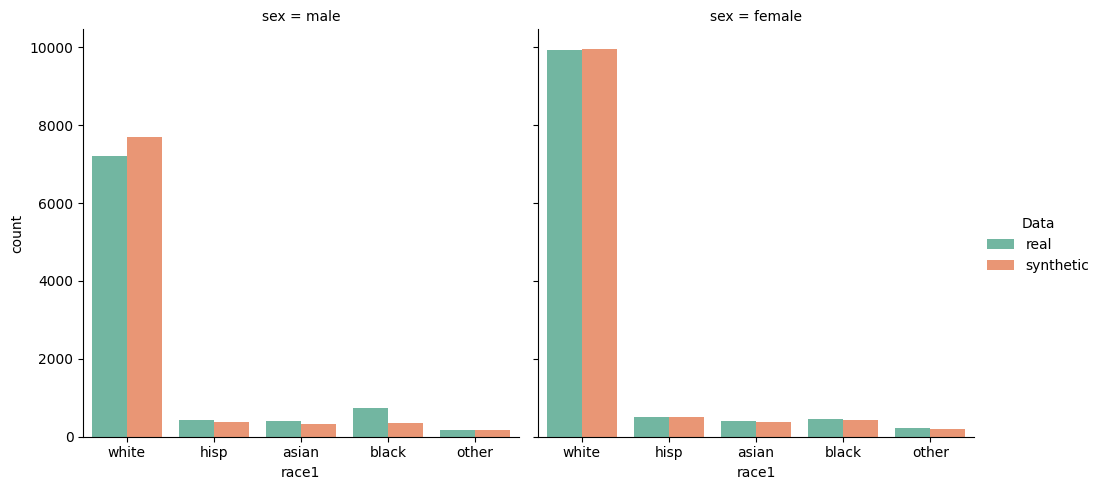

In [21]:
column_name1 = 'sex'
column_name2 = 'race1'

sns.catplot(x=column_name2,
    hue="Data",
    col=column_name1,
    data=combined_data,
    kind="count",
    palette='Set2')

<Figure size 800x500 with 0 Axes>

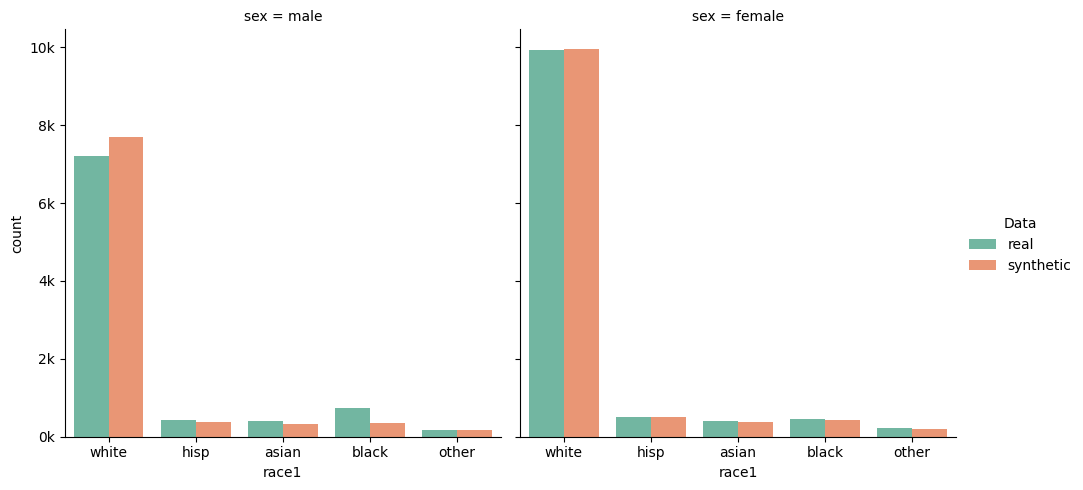

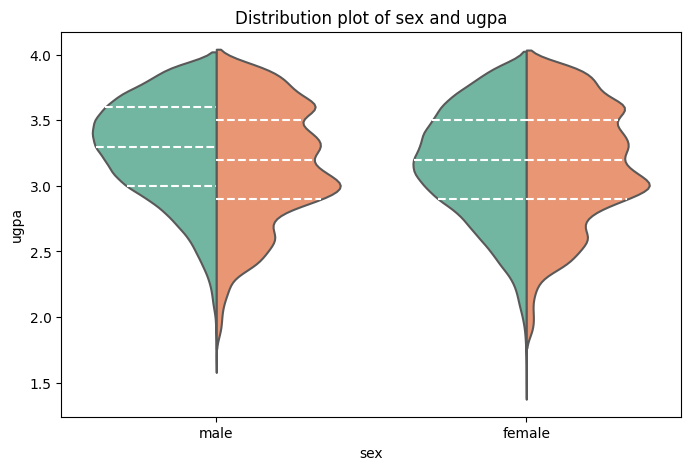

<Figure size 800x500 with 0 Axes>

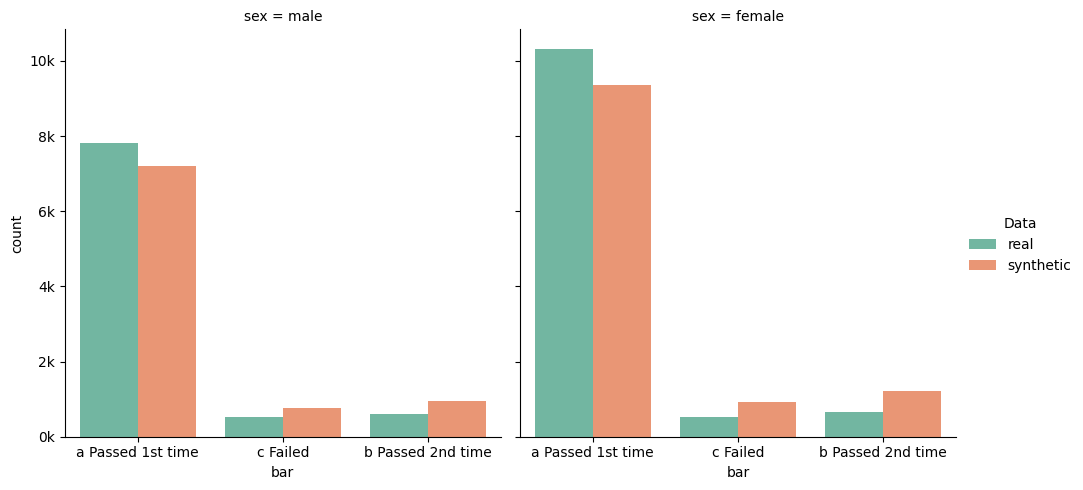

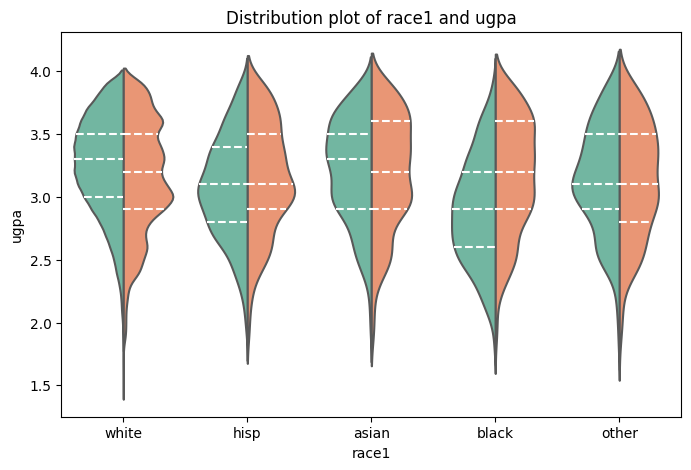

<Figure size 800x500 with 0 Axes>

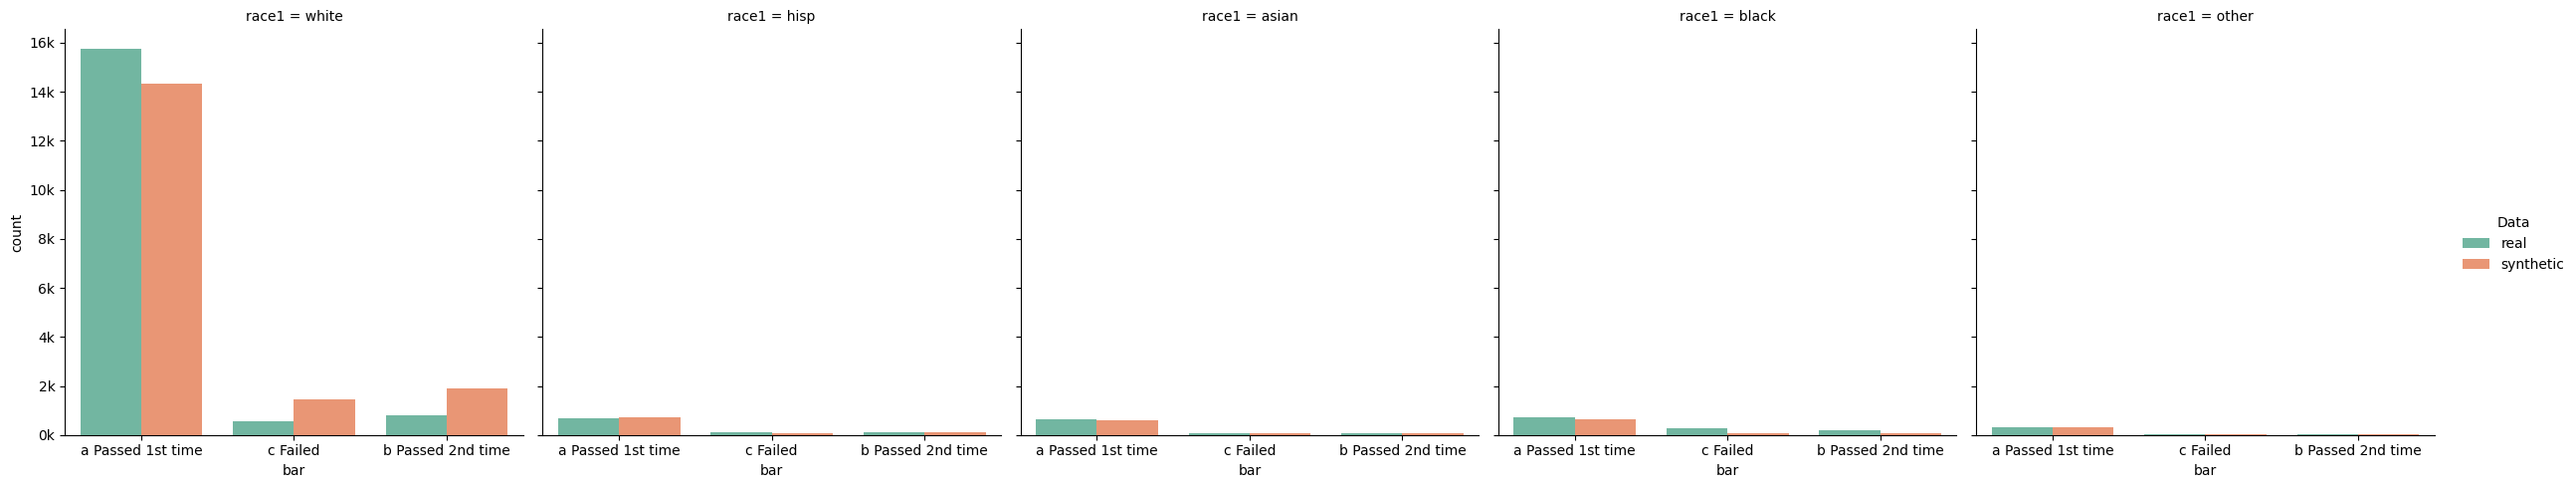

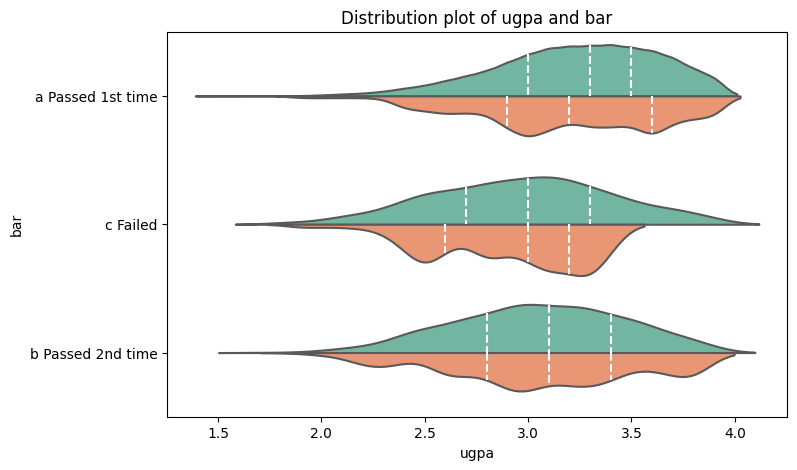

In [22]:
bivariate_plot(df, combined_data, dtypes_dict, Comparison=True)

#### 3.3 Correlation matrix

**UI text**

The matrix below illustrates the differences in pairwise correlations between variables in the original and synthetic data. Green cells signify that the pairwise correlation was accurately captured, with 0 representing the best possible score. Red cells indicate poor capture of the pairwise correlation, with scores of -2 and 2 representing the worst possible outcomes.

Text(0.5, 1.05, 'Absolute difference in correlation matrix, i.e., |real data - synthetic data|')

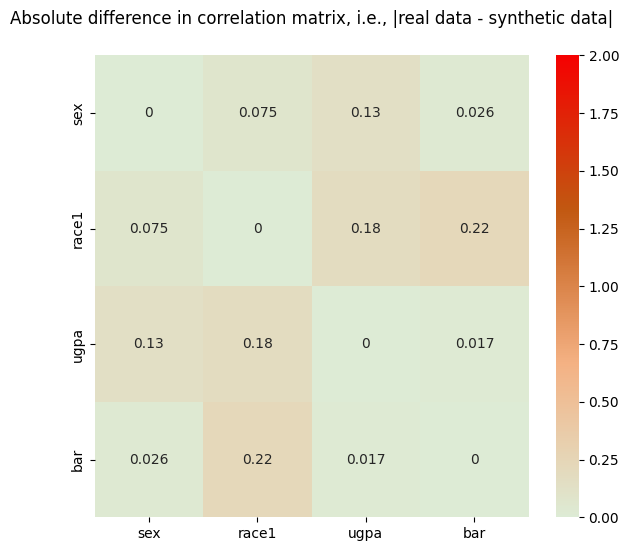

In [23]:
# Plot difference in correlation matrix between attached data and synthetic data
plt.figure(figsize=(7, 6))

# Define custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#ddebd5', '#f4b183', '#c15811', '#f50101'])

# Ensure the data is numeric for correlation calculation
df_numeric = df_encoded.apply(pd.to_numeric, errors='coerce')
synth_df_numeric = synth_df.apply(pd.to_numeric, errors='coerce')

# Plot correlation matrix for real_data
sns.heatmap(np.abs(df_numeric.corr() - synth_df_numeric.corr()), annot=True, cmap=cmap, vmin=0, vmax=2)
plt.title('Absolute difference in correlation matrix, i.e., |real data - synthetic data|', y=1.05)